In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
# Load the dataset
df = pd.read_csv('London_Listings.csv')

# Original shape
print('Original Shape:', df.shape)

# First 5 rows
df.head()

Original Shape: (66679, 31)


,id,name,description,host_id,host_name,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,...,amenities,price,minimum_nights,maximum_nights,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,calculated_host_listings_count
0,2.763150e+07,1,NaN,35877912,Alex,15/06/2015,NaN,NaN,f,1.0,...,"[""Kitchen"", ""Refrigerator"", ""Microwave"", ""Free...",$200.00,1,1125,14/06/2024,0,NaN,NaN,NaN,1
1,1.100000e+18,1,Get comfortable and enjoy plenty of extra room...,564055882,Lili-Ann,26/02/2024,NaN,NaN,f,1.0,...,[],$675.00,1,365,15/06/2024,0,NaN,NaN,NaN,1
2,1.170000e+18,117,Keep it simple at this peaceful and centrally-...,528033284,Shujauddin,26/07/2023,86%,50%,f,2.0,...,"[""Washer"", ""Wifi"", ""Kitchen""]",$95.00,1,365,16/06/2024,0,NaN,NaN,NaN,2
3,8.730000e+17,- Bright Central London Apartment -,My apartment has everything you possibly need ...,99268099,Alex,11/10/2016,98%,93%,t,5.0,...,"[""Microwave"", ""Hot water kettle"", ""Body soap"",...",$166.00,7,365,16/06/2024,24,24/04/2023,02/05/2024,4.83,1
4,4.672403e+07,""" Bright & Cosy Loft apartment """,Lovely and cosy arctic space with a separate d...,359199241,Karol,29/07/2020,100%,95%,t,1.0,...,"[""Cleaning products"", ""Cooking basics"", ""First...",$105.00,2,60,14/06/2024,46,20/08/2021,02/06/2024,4.89,1


In [4]:
# Check types before categorising

print(df.dtypes)

id                                float64
name                               object
description                        object
host_id                             int64
host_name                          object
host_since                         object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
host_listings_count               float64
host_total_listings_count         float64
neighbourhood                      object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms                         float64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
amenities                          object
price                              object
minimum_nights                    

In [5]:
# Categorial and numerical columns
categorical_var = df.select_dtypes(include=['object']).columns.tolist()
numerical_var = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Variables:", categorical_var)
print("Numerical Variables:", numerical_var)

Categorical Variables: ['name', 'description', 'host_name', 'host_since', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'calendar_last_scraped', 'first_review', 'last_review']
Numerical Variables: ['id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count']


In [6]:
# Price Column
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df['price'].describe()

count    61418.000000
mean       209.987202
std        961.450873
min          0.000000
25%         78.000000
50%        138.000000
75%        227.000000
max      80000.000000
Name: price, dtype: float64

In [7]:
# Categorical variables, remove empty strings or lists and replace with Nan.
for col in categorical_var:
    df[col] = df[col].replace(['', '[]'], np.nan)
    
missing_col_val = df.isnull().sum()
print('Missing column values:\n', missing_col_val[missing_col_val > 0])

Missing column values:
 description                   1956
host_name                        1
host_since                       1
host_response_rate           10175
host_acceptance_rate          7146
host_is_superhost              380
host_listings_count              1
host_total_listings_count        1
bathrooms                     5329
bathrooms_text                 100
bedrooms                       101
beds                          5400
amenities                      136
price                         5261
first_review                 14736
last_review                  14736
review_scores_rating         14736
dtype: int64


In [8]:
# Drop unnecessary columns, can be later changed.
drop_columns = ['calendar_last_scraped', 'bathrooms_text', 'latitude', 'longitude']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Updated shape
print("Shape after dropping unnecessary columns:", df.shape)

Shape after dropping unnecessary columns: (66679, 27)


In [9]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop rows with NaN values
df.dropna(inplace=True)

# Updated shape
print('Shape after dropping duplicates and NaN rows:', df.shape)

Shape after dropping duplicates and NaN rows: (41888, 27)


In [10]:
# Remove outliers (ONLY RUN ONCE)

def remove_outliers(df, columns):
    for col in columns:
        if col not in df.columns:
            print(f"Column '{col}' does not exist. Skipping.")
            continue
        
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Apply outlier removal
df = remove_outliers(df, numerical_var)

# Updated shape
print('Shape after removing outliers:', df.shape)

Column 'latitude' does not exist. Skipping.
Column 'longitude' does not exist. Skipping.
Shape after removing outliers: (19275, 27)


In [11]:
# Log transformation of prices

df = df[df['price'] > 0]  # Ensure no zero or negative prices
df['price_log'] = np.log1p(df['price'])

In [ ]:
# Update variable
numerical_var = [
    'accommodates', 'bedrooms', 'beds', 'price_log', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count'
]

# Create a copy before normalization
df_original = df.copy()

# Normalize numerical features
scaler = StandardScaler()
df[numerical_var] = scaler.fit_transform(df[numerical_var])

# Display updated dataframe
print(df.head())

              id                                               name  \
4   4.672403e+07                  " Bright & Cosy  Loft apartment "   
7   1.688942e+07  "Blue heaven"-chic House in quiet central loca...   
8   9.590000e+17  "Bohemian Luxury" Unique London Pub Now Posh Home   
11  9.530000e+17                           "Charming & Cozy Studio"   
12  1.140000e+18                               "Chic Urban Retreat”   

                                          description    host_id host_name  \
4   Lovely and cosy arctic space with a separate d...  359199241     Karol   
7   Pretty light-filled Victorian 3 storey house w...   21917428    Vivien   
8   Welcome to The Britannia in Shoreditch. This i...  195918146  Caroline   
11  Our studio is ideally situated within easy rea...  530597694    Silvia   
12  This fully-furnished apartment offers the perf...  480888562   Jessica   

    host_since host_response_rate host_acceptance_rate host_is_superhost  \
4   29/07/2020              

In [ ]:
# df.to_csv('cleaned_dataset.csv', index=False)

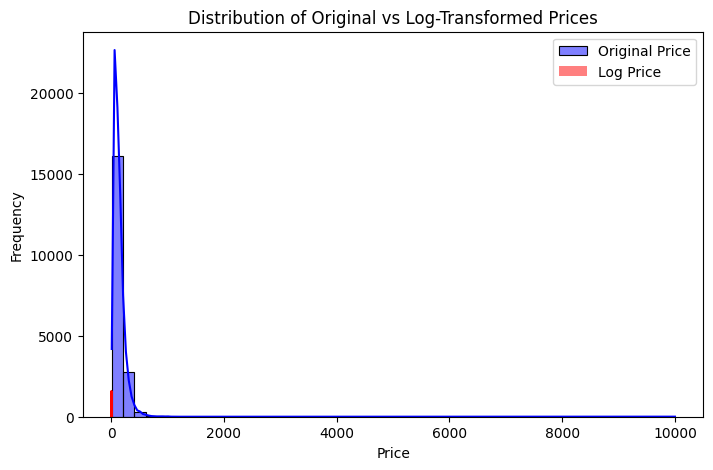

In [19]:
# Visualization: Log Price Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_original['price'], bins=50, kde=True, color='blue', label='Original Price')
sns.histplot(df_original['price_log'], bins=50, kde=True, color='red', label='Log Price')
plt.legend()
plt.title('Distribution of Original vs Log-Transformed Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

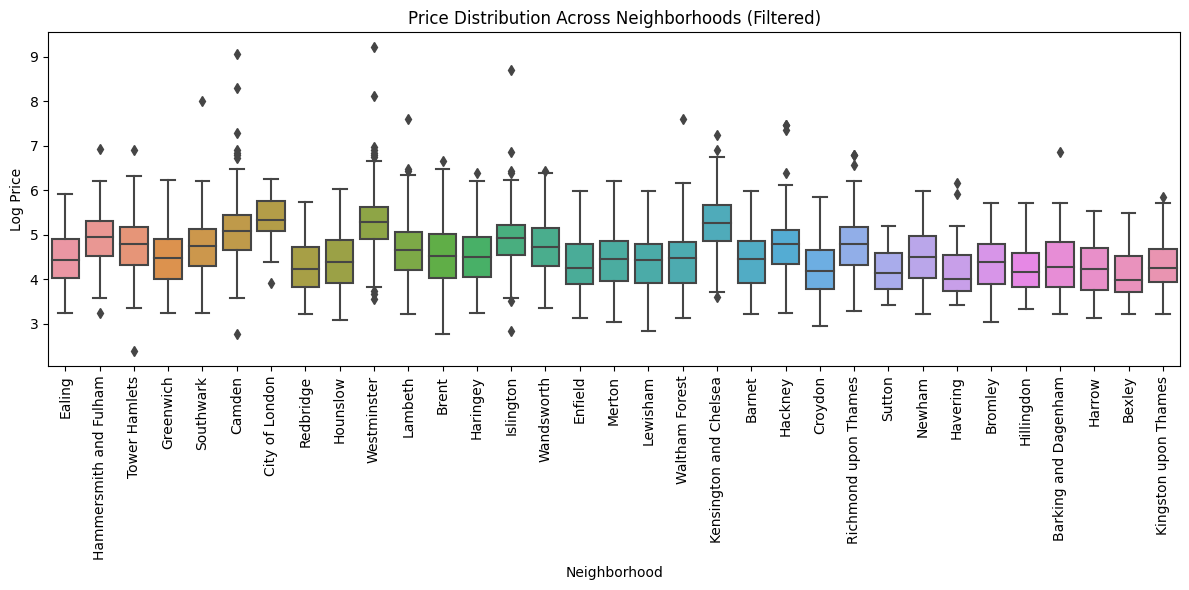

In [15]:
# Visualization: Price Across Neighborhoods
neighbourhood_counts = df_original['neighbourhood'].value_counts()
valid_neighbourhoods = neighbourhood_counts[neighbourhood_counts >= 10].index
df_filtered = df_original[df_original['neighbourhood'].isin(valid_neighbourhoods)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='neighbourhood', y='price_log')
plt.xticks(rotation=90)
plt.title('Price Distribution Across Neighborhoods (Filtered)')
plt.xlabel('Neighborhood')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

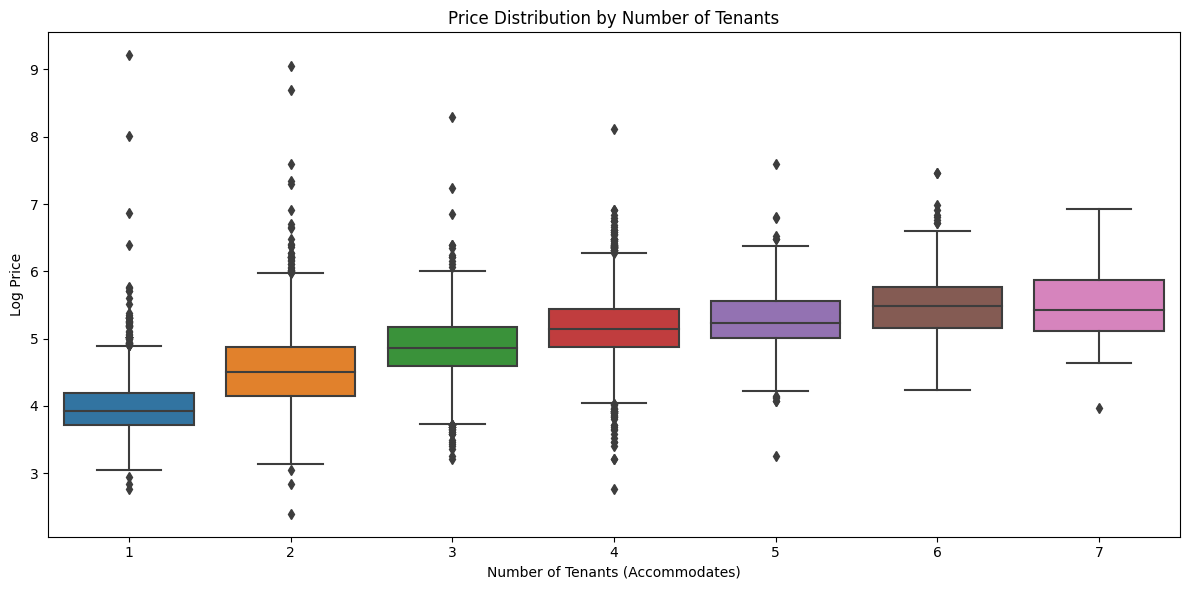

In [16]:
# Visualization: Price by Number of Tenants (Accommodates)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_original, x='accommodates', y='price_log')
plt.title('Price Distribution by Number of Tenants')
plt.xlabel('Number of Tenants (Accommodates)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()


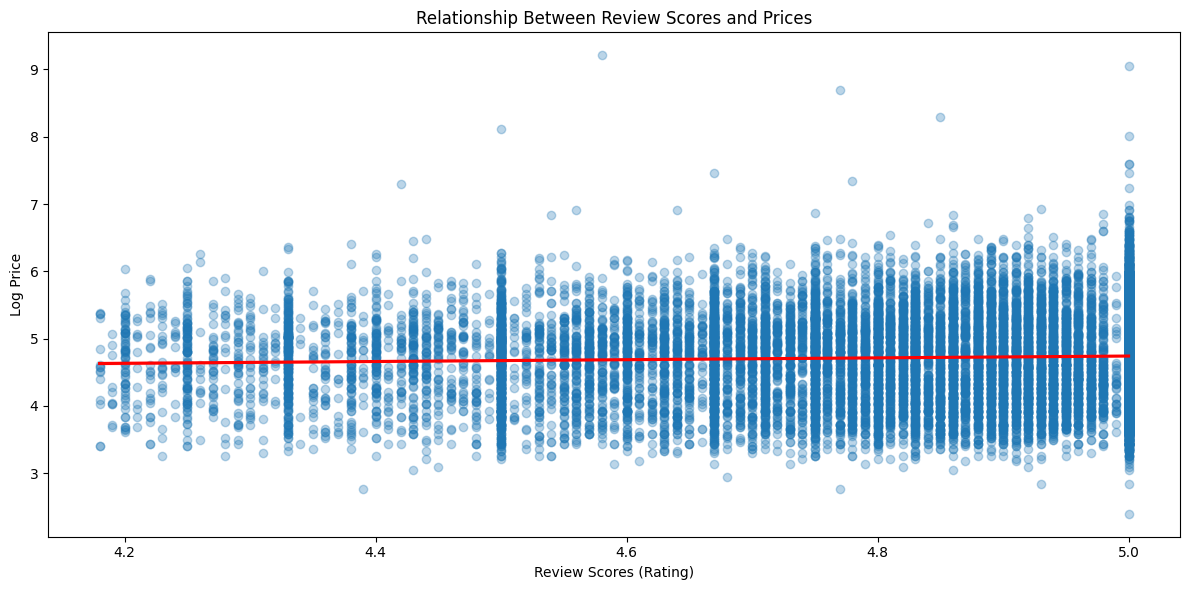

In [17]:
# Visualization: Relationship Between Review Scores and Prices
plt.figure(figsize=(12, 6))
sns.regplot(
    data=df_original,
    x='review_scores_rating',
    y='price_log',
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title('Relationship Between Review Scores and Prices')
plt.xlabel('Review Scores (Rating)')
plt.ylabel('Log Price')
plt.tight_layout()
plt.show()

## Most important cells

- `Neigbhourhood, Property Type, Room Type, Accomodates, Bedrooms, Beds, Minimum Nights, Number of Reviews, Review Rating, Host is Superhost, Host listing amounts, Calculated Host Listings Count`

## Useless (Potentially)

- `Id, Name, Host id, Host name, Host since` - No influence at all.
- `Amenities` - contains lists of items in the airbnb, won't affect price.
- `First Review, Last Review` - won't affect price

#

## Categorical Variables

Possible Approach
1) One Hot Encode

Converts categorical variables into a binary format.

## Numerical Variables
    'accommodates', 'bedrooms', 'beds', 'price_log', 'number_of_reviews', 'review_scores_rating', 'calculated_host_listings_count'




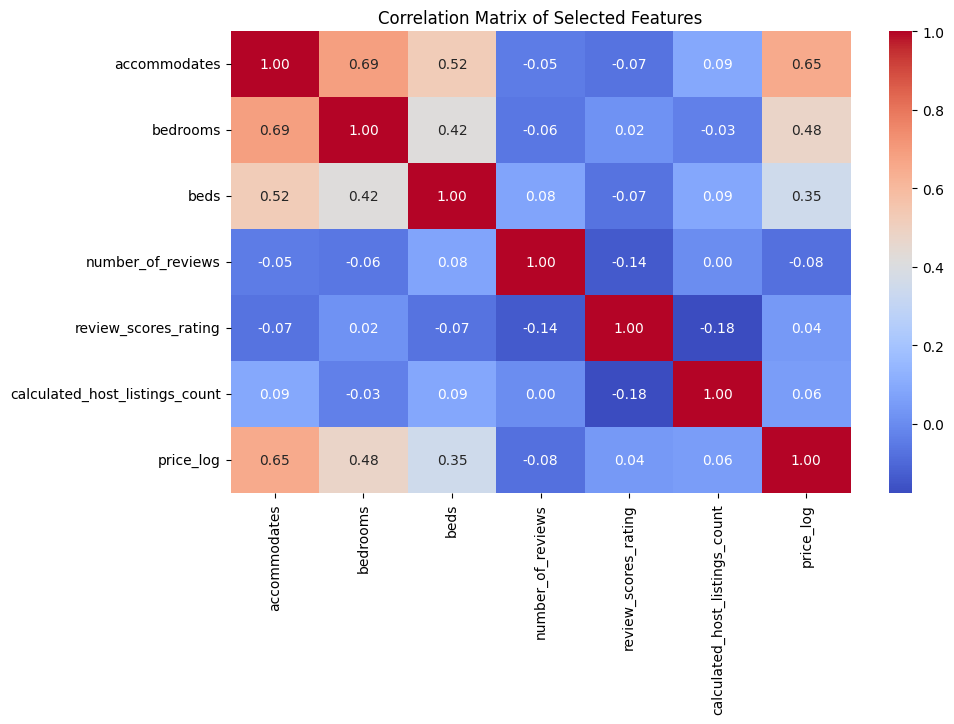

In [20]:
correlation_features = [
    'accommodates', 'bedrooms', 'beds', 'number_of_reviews', 
    'review_scores_rating', 'calculated_host_listings_count', 'price_log'
]

# Compute correlation matrix
correlation_matrix = df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.show()

### Strong Correlations

- `accommodates` (0.65 correlation with price_log) → More guests increase price significantly.
- `bedrooms` (0.48 correlation with price_log) → More bedrooms increase price.
- `beds` (0.35 correlation with price_log) → More beds slightly increase price.

### Weak Correlations

- `number_of_reviews` (-0.08 correlation with price_log) → Almost no effect on price.
- `review_scores_rating` (0.04 correlation with price_log) → Minimal effect on price.
- `calculated_host_listings_count` (0.06 correlation with price_log) → Negligible effect.